<a href="https://colab.research.google.com/github/Davilirio/Python_data_analysis/blob/master/AB_NYC_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importando as dependencias

In [ ]:
from fastai.imports import *
from fastai.tabular import * 
from google.colab import drive, files
from shapely.geometry import Point, Polygon
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline
sns.set(style="darkgrid")
plt.style.use('seaborn-dark')

drive.mount('/content/my_drive/')
path = Path('/content/my_drive/My Drive/preprocessing')

Drive already mounted at /content/my_drive/; to attempt to forcibly remount, call drive.mount("/content/my_drive/", force_remount=True).


###**Questão 2**: ​ Crie um script em ​ Python​ ou ​ Node.js ​ que carrega os dados do dataset e, como saída, crie um arquivo CSV somente as seguintes colunas do dataset original:
###**id​** , ​ **host_id**​ , ​ **price**​ , ​ **number_of_reviews​** , ​ **last_review​** (0,5 ponto).

In [ ]:
# lendo o arquivo:
df = pd.read_csv(path/'AB_NYC_2019.csv')
# lista de colunas desejadas:
desired_cols = ['id', 'host_id','price','number_of_reviews','last_review']
# filtrando por coluna:
df_filtered = df[desired_cols]
# visualizacao do df criado:
df_filtered.head()

,id,host_id,price,number_of_reviews,last_review
0,2539,2787,149,9,2018-10-19
1,2595,2845,225,45,2019-05-21
2,3647,4632,150,0,NaN
3,3831,4869,89,270,2019-07-05
4,5022,7192,80,9,2018-11-19


In [ ]:
# criando o arquivo em formato CSV
df_filtered.to_csv(path/'AB_NYC_2019_filtered.csv',
                   columns=df_filtered.columns.values)

#### Checagem do resultado:

In [ ]:
# como o csv nao possui metadata de index, torna-se necessario avisar 
# qual coluna se comporta como index do df:
result_check=pd.read_csv(path/'AB_NYC_2019_filtered.csv', index_col='Unnamed: 0')
result_check.head()

,id,host_id,price,number_of_reviews,last_review
0,2539,2787,149,9,2018-10-19
1,2595,2845,225,45,2019-05-21
2,3647,4632,150,0,NaN
3,3831,4869,89,270,2019-07-05
4,5022,7192,80,9,2018-11-19


### **Questão 3**: ​ Visando analisar a variação do preço de locação dos hosts, descreva de forma clara e organizada, o tratamento de dados você utilizaria sobre o dataset em questão,englobando pré-processamento, análise textual, algoritmos de mineração de dados,ferramentas de data discovery ou qualquer outra forma/técnica que seja de seuconhecimento. Para esta questão será considerado o processo aplicado sobre o conjunt de dados, visando extrair informações relevantes sobre os dados que possam influenciar no preço de locação do host. ​ (2 pontos)

#### Em busca de procurar relações entre as variáveis disponibilizadas no dataset com o preço dos imóveis para locação, seria necessário procurar relações individuais entre as colunas que possuem possível impacto com a variável dependente (neste exemplo: preço). Há diversas metodologias possíveis para a obtenção destas relações, entre elas existem metodologias estatísticas de regressão linear, onde os Betas do modelo seguinte seriam os parametros de impacto de cada variavel no modelo. 

\begin{align} 
price = \beta_0 X_0 + \beta_1 X_1 + ...+ \beta_n X_n + residuos
\end{align}

#### Para que isto seja possivel, é de bom costume checar os impactos individuais entre cada variavel no preço do imóvel, buscando inicialmente via análise gráfica relações visíveis com a variável exógena. Neste caso, iniciamos com a limpeza do dataset, deixando apenas colunas de interesse. No caso atual, retiramos a variável de nome do *listing* e nome do *host*, que se mostram desnecessárias em análise ainda em análise superficial. Em seguida, tornamos para a seleção de apenas locais que possuem quantia significativa de dados, para que locais pouco representativos no dataset não viesem o modelo de forma não realista, para isto, selecionamos apenas os *ids* que mais aparecem entre os dados. 
#### Concluida tal etapa, buscamos agora relações entre os locais com o preço, sendo, com os resultados demonstrados abaixo, perceptível que há relação entre bairro e preço, o que é esperado em dados imobiliários. Na busca de maior entendimento do problema, plotamos as coordenadas espaciais dos 20 locais mais baratos, em comparação com os 20 locais mais caros. Seguimos para a checagem de se o número de reviews se comporta de forma correlata com os preços, o que não se mostra correlato em análise individual, portanto seguimos para a checagem agrupada com os bairros em busca da checagem da hipotese do número de reviews impactar os preços após a escolha do bairro, o que não se mostra realista também, dado que graficamente o valor se mostra estacionário em uma média. No entanto, tal variável ainda será utilizada na análise pois possui sentido racional.
#### Às variáveis categoricas, seria aplicado o processo de criação de dummies para que 

In [ ]:
df = pd.read_csv(path/'AB_NYC_2019.csv')
df.drop(columns = ['name', 'host_name'], inplace = True)
df.head()

,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [ ]:
df.fillna({'reviews_per_month':0}, inplace=True)

In [ ]:
## 50 bairros que mais constam no df:
top_50 = (df.groupby('neighbourhood')['id'].count()
                                             .sort_values(ascending = False)[:50])

df_50 = df.loc[df['neighbourhood'].isin(top_50.index.values)]

print('10 bairros com maior numero de reviews: \n'), top_50[:10]

10 bairros com maior numero de reviews: 



(None, neighbourhood
 Williamsburg          3920
 Bedford-Stuyvesant    3714
 Harlem                2658
 Bushwick              2465
 Upper West Side       1971
 Hell's Kitchen        1958
 East Village          1853
 Upper East Side       1798
 Crown Heights         1564
 Midtown               1545
 Name: id, dtype: int64)

In [ ]:
## Nota-se que ha diferenca significativa de precos entre os bairros:
bairros_mais_caros = df_50.groupby('neighbourhood')['price'].mean().sort_values(ascending = False)

print('Bairros mais caros: \n'),bairros_mais_caros[:10]

Bairros mais caros: 



(None, neighbourhood
 SoHo                  287.103352
 Midtown               282.719094
 West Village          267.682292
 Greenwich Village     263.405612
 Chelsea               249.738544
 Theater District      248.013889
 Nolita                230.138340
 Financial District    225.490591
 Gramercy              222.754438
 Murray Hill           220.958763
 Name: price, dtype: float64)

In [ ]:
bairros_mais_baratos = df_50.groupby('neighbourhood')['price'].mean().sort_values()
print('Bairros mais baratos: \n'),bairros_mais_baratos[:10]

Bairros mais baratos: 



(None, neighbourhood
 Ridgewood             77.184397
 Elmhurst              80.459916
 Jackson Heights       80.897849
 East Elmhurst         81.183784
 Bushwick              84.800406
 Sunnyside             84.865014
 Woodside              85.097872
 East New York         85.426606
 Inwood                88.896825
 Washington Heights    89.610679
 Name: price, dtype: float64)

##### Nota-se que ha separacao entre os locais mais baratos dos mais caros, como esperado. Os locais com maior preco se concentram, enquanto os de menor sao mais distribuidos. Entende-se que os de maior preco se concentram no centro da cidade de nova iorque.

##### Nota-se que o numero de reviews por si nao representa impacto significativo nos precos das estadias, no entanto pode ser utilizado como variavel em uma analise conjunta do impacto das variaveis sobre o preco do local


In [ ]:
df_50.groupby('number_of_reviews')['price'].mean().index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            480, 488, 510, 540, 543, 576, 594, 597, 607, 629],
           dtype='int64', name='number_of_reviews', length=386)

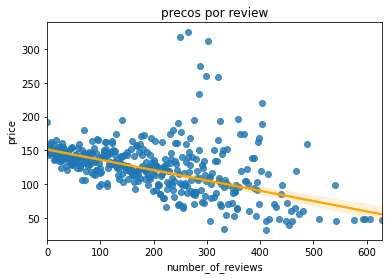

In [ ]:
sns.regplot(df_50.groupby('number_of_reviews')['price'].mean().index,
            df_50.groupby('number_of_reviews')['price'].mean(),
            ci = 95, line_kws={'color': 'orange'}, robust = True)
plt.title('precos por review')
plt.show()

##### Analisando o impacto de bairro + numero de reviews:

In [ ]:
bairro_num = df_50.groupby(['neighbourhood', 'number_of_reviews'])['price'].mean().sort_values(ascending = False)
bairro_num = pd.DataFrame(bairro_num).sort_values('neighbourhood')
bairro_num.sort_index(inplace = True)

##### Nota-se que dentro de um bairro, o número de reviews tambem nao se mostra correlato com o preço em si. Há a possibilidade de atuar em niveis ainda menores de granularidade, tendo impacto após a seleção de outras n variááveis.

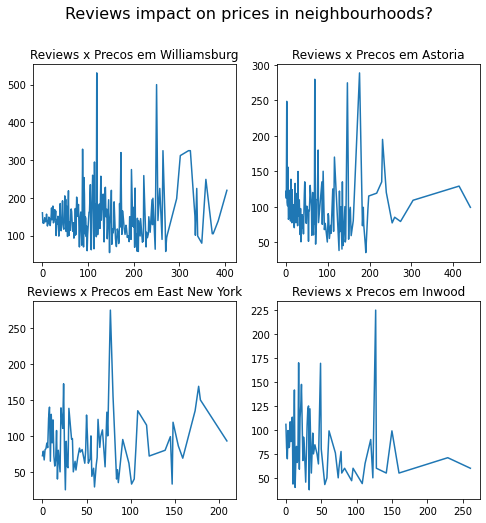

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (8, 8))

ax[0,0].plot(bairro_num.loc['Williamsburg'])
ax[0,0].set_title('Reviews x Precos em Williamsburg')

ax[0,1].plot(bairro_num.loc['Astoria'])
ax[0,1].set_title('Reviews x Precos em Astoria')

ax[1,0].plot(bairro_num.loc['East New York'])
ax[1,0].set_title('Reviews x Precos em East New York')

ax[1,1].plot(bairro_num.loc['Inwood'])
ax[1,1].set_title('Reviews x Precos em Inwood')

fig.suptitle('Reviews impact on prices in neighbourhoods?', size = 16)
fig.show()

##### Geralmente locais inteiros possuem precos maiores, logo conseguimos inserir estes dados no modelo em forma numericalizada,

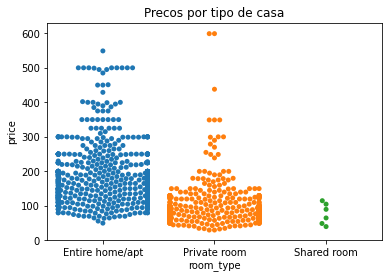

In [ ]:
menor_600 = df_50.loc[df_50['price'] < 600]

ax = sns.swarmplot(x = menor_600[:1000]['room_type'], y = menor_600[:1000]['price'],)
ax.set_ylim(0, 630)
ax.set_title('Precos por tipo de casa')
plt.show()

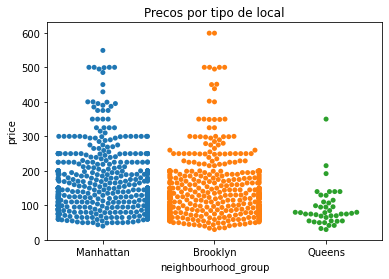

In [ ]:
menor_600 = df_50.loc[df_50['price'] < 600]

ax = sns.swarmplot(x = menor_600[:1000]['neighbourhood_group'], y = menor_600[:1000]['price'],)
ax.set_ylim(0, 630)
ax.set_title('Precos por local')
plt.show()

##### Montando algoritmo de previsao de precos:

In [ ]:
df.columns

Index(['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

In [ ]:
# tornando as variaveis categoricas para o formato category, onde seu valor em
# memoria sera guardado como numero, o que torna a regressao possivel
cats = ['neighbourhood_group', 'neighbourhood', 'room_type']
for i in cats:
  df_50[i] = df_50[i].astype('category')
  df_50[f'{i}_cat'] = df_50[i].cat.codes;

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_50.columns

Index(['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'neighbourhood_group_cat', 'neighbourhood_cat', 'room_type_cat'],
      dtype='object')

In [ ]:
Y = df_50['price']
x = df_50[['latitude',
       'longitude', 'price', 'minimum_nights',]]

In [ ]:
modelo = sm.OLS(endog = Y, exog = x)
modelo_fitted = modelo.fit()

In [ ]:
modelo_fitted.params

latitude         -5.053180e-13
longitude        -2.734896e-13
price             1.000000e+00
minimum_nights    1.335854e-16
dtype: float64

In [ ]:
a = [i for i in df.columns if i not in x]
a.append('price')
previsao = modelo_fitted.predict(df_50[:1].drop(a, axis = 1))

KeyError: ignored

In [ ]:
 df_50[:1].drop(a, axis = 1)

,latitude,longitude,minimum_nights,neighbourhood_group_cat,neighbourhood_cat,room_type_cat
1,40.75362,-73.98377,1,1,31,0


In [ ]:
a = [i for i in df.columns if i not in x]
a.append('price')
a

['id',
 'host_id',
 'neighbourhood_group',
 'neighbourhood',
 'room_type',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'price']

### Questão 4. ​ Imagine que você é um analista de dados no ​ Airbnb ​ (empresa fornecedora dos dados) e lhe foi solicitada a criação de visualizações para entender melhor o que vem acontecendo com os aluguéis na cidade de Nova Iorque. Utilizando alguma ferramenta de visualização (PowerBI, Tableau, Excel, Metabase, Data Studio, etc) para realizar a ingestão do dataset, crie visualizações conforme as questões abaixo solicitadas. ​ Justifique cada escolha de visualização (tipo de gráfico e cores utilizadas), descreva qual ferramenta utilizou e ​ disponibilize o respectivo arquivo exportado da própria ferramenta​ , para correção.

####**a)** Quantidade de reviews agrupados pela coluna ​ neighbourhood​ . ​ (0,5 ponto). 
#### Justifique
suas escolhas (0,5 ponto);

##### Por sua natureza categórica, utilizei na criação da visualização cores discrepantes para cada bairro analisado. Sendo por costume da paleta darkgrid da ferramenta seaborn, plotar em azul o primeiro valor. As colunas são renomeadas para seus nomes em português e o título é explicativo em português

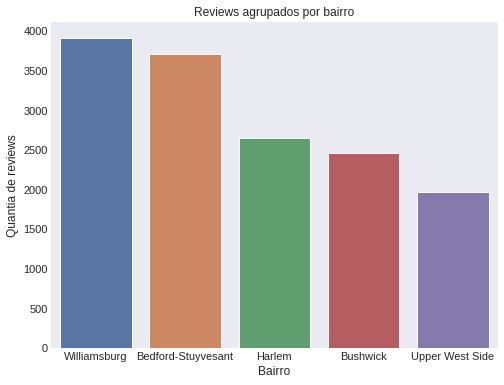

In [ ]:
review_nh = pd.DataFrame(df.groupby('neighbourhood')['number_of_reviews']
             .count().sort_values(ascending = False)[:5]).reset_index()

fig, ax = plt.subplots(figsize = (8, 6))
ax = sns.barplot(x= 'neighbourhood', y='number_of_reviews', data=review_nh)
ax.set_ylabel('Quantia de reviews')
ax.set_xlabel('Bairro')
ax.set_title('Reviews agrupados por bairro')
fig.show()

##### **b)** Média da coluna ​ minimum_nights ​ agrupado pela coluna ​ room_type. (0,5 ponto).
#### Justifique suas escolhas (0,5 ponto);

##### Para esta plotagem, foi utilizada a própria linguagem python. Como a plotagem refere-se à dados categóricos, são utilizadas cores diferentes para cada conjunto para que haja discrepância visual entre às cores selecionadas na paleta para este problema. O formato de barra é de simples entendimento, uma vez que analisando apenas sua altura percebemos sua participação total nos dados. Colunas também renomeadas e título explicativo para tornar a visualização simples e informativa sobre seu propósito

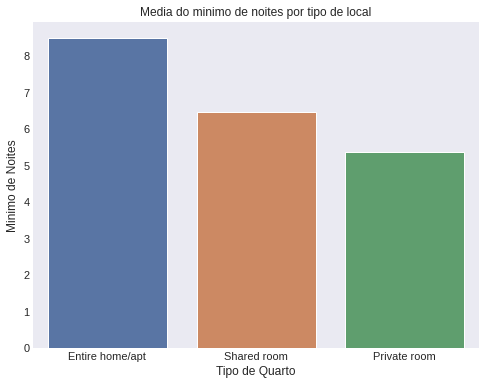

In [ ]:
min_nights = pd.DataFrame(df.groupby('room_type')['minimum_nights']
             .mean().sort_values(ascending = False)).reset_index()

fig, ax = plt.subplots(figsize = (8, 6))
ax = sns.barplot(x= 'room_type', y='minimum_nights', data=min_nights)
ax.set_xlabel('Tipo de Quarto')
ax.set_ylabel('Minimo de Noites')
ax.set_title('Media do minimo de noites por tipo de local')
fig.show()

#### c) Utilizando as colunas ​ latitude ​ e ​ longitude,​ crie uma visualização geográfica (mapa) dos hosts presentes no dataset (0,5 ponto). Enriqueça o mapa com a utilização de cores e/ou tamanho de ponto diferenciado para outras características como preço, número mínimo de noites, número de reviews, tipo de quarto, por exemplo ​ (0,5 ponto). Justifique cada escolha (0,5 ponto);

##### Por estar utilizando a plataforma linux, nao tenho acesso ao PowerBI, onde sei plotar com visualização de mapa ao fundo. No entanto, segue visualização com pontos geográficos em python (no google colab nao há o pacote basemaps), onde os 20 locais mais caros estão na área em laranja e os 20 mais baratos em azul. Seus tamanhos são ponderados pelo preço da estadia. A ideia é simplificar o entendimento de quem vê, deixando em cores mais fortes os locais de maior preço, enquanto os mais baratos e mais frequentes em azul. O tamanho é multiplicado por fator menor na área mais cara, onde seu valor é diversas vezes maior.

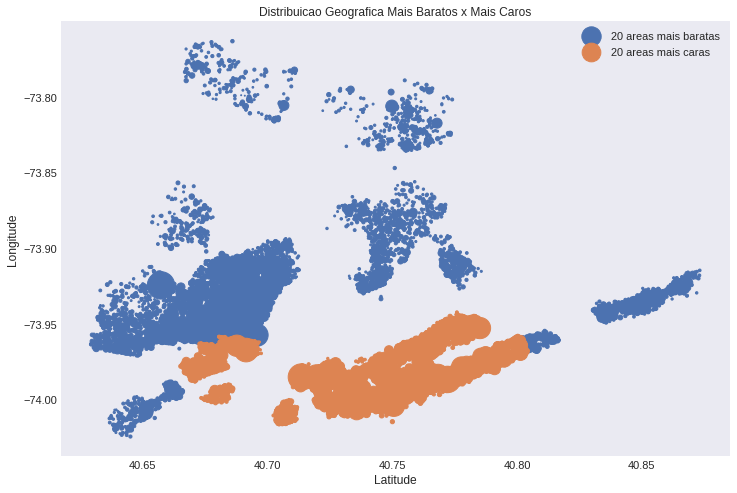

In [ ]:
mais_caros = df_50.loc[df_50['neighbourhood'].isin(bairros_mais_caros.index[:20].values)]
mais_baratos = df_50.loc[df_50['neighbourhood'].isin(bairros_mais_baratos.index[:20].values)]
# distribuicao Geografica dos mais caros x mais baratos
fig, ax = plt.subplots(figsize = (12, 8))

ax.scatter(x=mais_baratos['latitude'], y = mais_baratos['longitude'],label = '20 areas mais baratas',
           s=mais_baratos['price']*0.1)
ax.scatter(x=mais_caros['latitude'], y = mais_caros['longitude'], label = '20 areas mais caras', s=mais_caros['price']*0.07 )

ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_title('Distribuicao Geografica Mais Baratos x Mais Caros')
ax.legend()
fig.show()

#### **d)** Suponhamos que foi solicitada uma visualização que mostre o número de reviews recebidos por mês em um determinado imóvel. Estes dados fictícios foram disponibilizados no ​ item 3. dos anexos​ . Crie uma visualização que mostre o número de reviews recebidos por mês (0,5 ponto). Justifique suas escolhas (0,5 ponto)

##### Como os dados vieram em formato temporal, a plotagem se torna melhor em linha, uma vez que há o entendimento de continuidade. Para checarmos o movimento temporal, foi utilizado o parametro de media movel para checarmos a media dos valores ao longo do tempo, o que se mostrou crescente até o último período checado.

In [ ]:
serie_temporal = pd.read_csv(path/'dados_teste_analistaDados.csv')
serie_temporal['data'] = pd.to_datetime(serie_temporal['data'],
                                        format = '%Y-%m-%d')
serie_temporal.set_index('data', inplace=True)

suavizacao =media_temporal_ponderada(serie_temporal['reviews'], 0.1, 0.8)
serie_temporal['media_movel']=serie_temporal['reviews'].expanding(min_periods=4).mean()

Index(['reviews'], dtype='object')

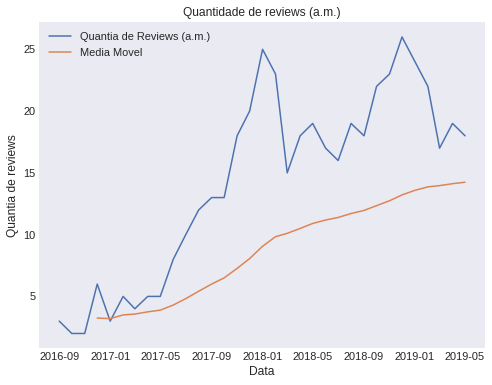

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))

ax.plot(serie_temporal['reviews'], label = 'Quantia de Reviews (a.m.)')
ax.plot(serie_temporal['media_movel'], label = 'Media Movel')

ax.set_xlabel('Data')
ax.set_ylabel('Quantia de reviews')
ax.set_title('Quantidade de reviews (a.m.)')

ax.legend()
fig.show()